# Car racing using simple DQN & Viz dev

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[-1], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._calculate_conv_output(input_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)

    def _calculate_conv_output(self, input_shape: tuple) -> int:
        o = torch.zeros(1, *reversed(input_shape))
        o = self.conv1(o)
        o = self.conv2(o)
        o = self.conv3(o)
        return int(np.prod(o.size()))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQNAgent:
    def __init__(self, input_shape: tuple, num_actions: int, memory_size: int, batch_size: int, gamma: float, epsilon: float, lr: float):
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_actions = num_actions

        self.policy_net = DQN(input_shape, num_actions).to(device)
        self.target_net = DQN(input_shape, num_actions).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.update_target_net()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def select_action(self, state: torch.Tensor):
        if random.random() < self.epsilon:
            return random.randrange(self.num_actions)
        with torch.no_grad():
            return self.policy_net(state).argmax(dim=1).item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(torch.stack(states, dim=1).squeeze(0), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(torch.stack(next_states, dim=1).squeeze(0), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = nn.functional.mse_loss(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [6]:
env = gym.make("CarRacing-v2", continuous=False)
input_shape = env.observation_space.shape
num_actions = env.action_space.n

agent = DQNAgent(input_shape, num_actions, memory_size=10000, batch_size=64, gamma=0.99, epsilon=0.1, lr=1e-4)

num_episodes = 1000
target_update_frequency = 10

for episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).view((-1, 3, 96, 96))
    total_reward = 0

    for _ in range(200):
        action = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0).view((-1, 3, 96, 96))
        total_reward += reward

        agent.memory.push(state, action, reward, next_state, done)
        state = next_state

        agent.train_step()

        if done:
            break

    if episode % target_update_frequency == 0:
        agent.update_target_net()

    print(f"Episode {episode}, Total Reward: {total_reward}")

C:\Users\janhe\AppData\Local\Temp\ipykernel_7980\1491307797.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(torch.stack(states, dim=1).squeeze(0), dtype=torch.float32, device=device)
C:\Users\janhe\AppData\Local\Temp\ipykernel_7980\1491307797.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.tensor(torch.stack(next_states, dim=1).squeeze(0), dtype=torch.float32, device=device)


Episode 0, Total Reward: 8.8808664259928
Episode 1, Total Reward: 5.974025974026045
Episode 2, Total Reward: 3.3333333333333717
Episode 3, Total Reward: 2.5806451612903794
Episode 4, Total Reward: 21.66666666666667
Episode 5, Total Reward: 16.363636363636278
Episode 6, Total Reward: 31.28205128205117
Episode 7, Total Reward: -5.185185185185176
Episode 8, Total Reward: -0.6451612903225789
Episode 9, Total Reward: 0.5479452054794737
Episode 10, Total Reward: -2.558139534883724
Episode 11, Total Reward: -3.221476510067088
Episode 12, Total Reward: 0.06688963210704432
Episode 13, Total Reward: 4.390243902439035
Episode 14, Total Reward: 1.97802197802199
Episode 15, Total Reward: -1.9277108433734949
Episode 16, Total Reward: 2.1518987341772253
Episode 17, Total Reward: 2.727272727272792
Episode 18, Total Reward: -0.5194805194805112
Episode 19, Total Reward: -3.3333333333333206
Episode 20, Total Reward: -6.06271777003482
Episode 21, Total Reward: 2.900763358778677
Episode 22, Total Reward: -

KeyboardInterrupt: 

In [31]:
import matplotlib.pyplot as plt

state, reward, done, truncated, info = env.step(0)
state = torch.tensor(state, device=device)
state.shape

torch.Size([96, 96, 3])

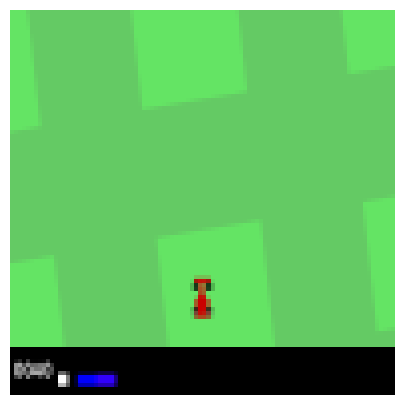

In [44]:
plt.figure(figsize=(5, 5))
plt.imshow(state)
plt.axis('off')
plt.show()

In [62]:
env.render()

In [64]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from pygame import display


# Set game resolution
WIN_SIZE = (1000, 1000)
display.init()

frames = []
env = gym.make("CarRacing-v2", continuous=False, render_mode="human")
env.reset()
display.set_mode(WIN_SIZE)


for i in range(100):
    env.render()
    s, r, terminated, truncated, info = env.step(3)  # 0-th action is no_op action
    frames.append(s)

# # Create animation
# fig = plt.figure(figsize=(5, 5))
# plt.axis('off')
# im = plt.imshow(frames[0])
# def animate(i):
#     img = frames[i]
#     im.set_array(img)
#     return im,
# anim = FuncAnimation(fig, animate, frames=len(frames))
# HTML(anim.to_jshtml())